In [1]:
import Pkg
Pkg.add("DifferentialEquations")
Pkg.add("Distributions")
Pkg.add("Turing")
Pkg.add("DiffEqBayes")
Pkg.add("ParameterizedFunctions")
Pkg.add("RecursiveArrayTools")
Pkg.add("DataFrames")

   Updating registry at `~/.julia/registries/General`


   Updating git-repo `https://github.com/JuliaRegistries/General.git`


    Fetching:

    Fetching: [==================>                      

    Fetching:

    Fetching: [====================================>    

Fetching: [========================================>]  100.0 %

  Resolving package versions...
  Installed Zlib_jll ─── v1.2.11+10
  Installed ZeroMQ_jll ─ v4.3.2+3
######################################################################### 100.0%
######################################################################### 100.0%
   Updating `~/.julia/environments/v1.4/Project.toml`
 [no changes]
   Updating `~/.julia/environments/v1.4/Manifest.toml`
  [8f1865be] ↑ ZeroMQ_jll v4.3.2+2 ⇒ v4.3.2+3
  [83775a58] ↑ Zlib_jll v1.2.11+9 ⇒ v1.2.11+10
  Resolving package versions...
   Updating `~/.julia/environments/v1.4/Project.toml`
 [no changes]
   Updating `~/.julia/environments/v1.4/Manifest.toml`
 [no changes]
  Resolving package versions...
   Updating `~/.julia/environments/v1.4/Project.toml`
 [no changes]
   Updating `~/.julia/environments/v1.4/Manifest.toml`
 [no changes]
  Resolving package versions...
   Updating `~/.julia/environments/v1.4/Project.toml`
 [no changes]
   Updating `~/.julia/environments/v1.4/Manifest.toml`
 [no changes]
  Resolving p

In [2]:
using DifferentialEquations
# p[1] = delta
# p[2] = m_ktl
# p[3] = beta
# p[4] = km
function gfp!(du,u,p,t)
 du[1] = -p[1]*u[1]
 du[2] = p[2]*u[1]-(p[3]+p[4])*u[2]
 du[3] = p[4]*u[2]-p[3]*u[3]
end

gfp! (generic function with 1 method)

In [3]:
u0 = [1.0,0.0,0.0]
tspan = (0.0,30.0)
p = [0.08,4e4,0.04,0.3]
prob = ODEProblem(gfp!,u0,tspan,p)

ODEProblem with uType Array{Float64,1} and tType Float64. In-place: true
timespan: (0.0, 30.0)
u0: [1.0, 0.0, 0.0]

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1260


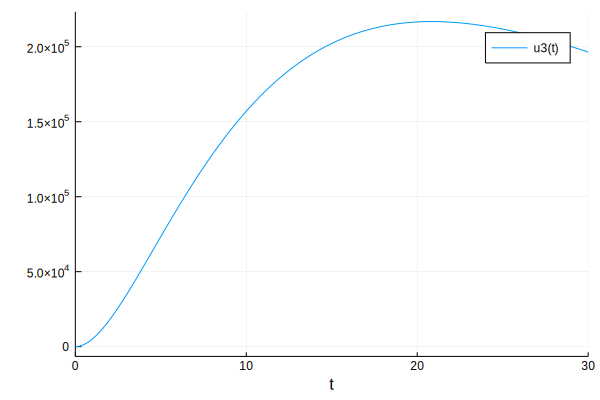

In [4]:
using Plots
sol = solve(prob)
plot(sol,vars=(0,3))

In [5]:
# p[1] = delta
# W = m_ktl
# p[3] = beta
# p[4] = km
function gfp_noise!(du,u,p,t,W)
 du[1] = -p[1]*u[1]
 du[2] = W*u[1]-(p[3]+p[4])*u[2]
 du[3] = p[4]*u[2]-p[3]*u[3]
end

gfp_noise! (generic function with 1 method)

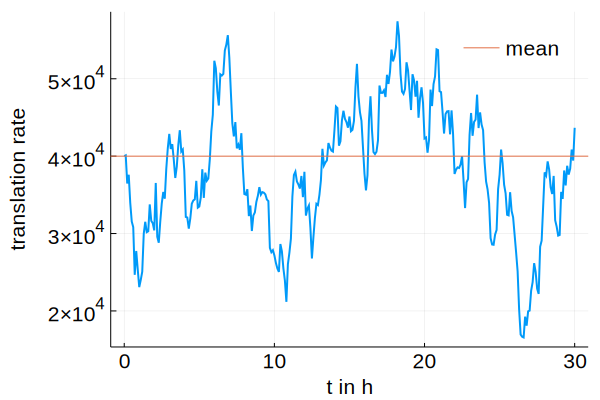

In [27]:
# amplitude squared is sigma^2/(2*Theta)
μ = 4e4
Θ = 0.5
σ = 0.3*sqrt(Θ)*μ
W = OrnsteinUhlenbeckProcess(Θ,μ,σ,0.0,μ)
probW = NoiseProblem(W,(0.0,30.0))
solW = solve(probW;dt=0.1)
t = [0:0.1:30.0]
fig=plot(t,solW.u,label="",lw=2,xlabel="t in h",ylabel="translation rate")
hline!([4e4],label="mean",
        xtickfontsize=14,
    ytickfontsize=14,
    xguidefontsize=14,
    yguidefontsize=14,
    legendfontsize=14,
foreground_color_legend = nothing)
png("OUexampl.png")
fig

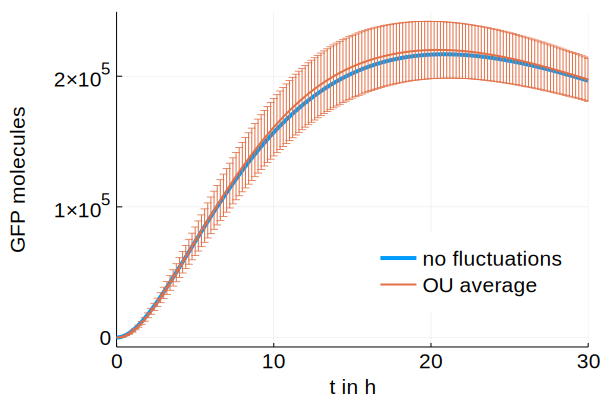

In [28]:
using Statistics
u0 = [1.0,0.0,0.0]
tspan = (0.0,30.0)
p = [0.08,4e4,0.04,0.3]
prob = RODEProblem(gfp_noise!,u0,tspan,p,noise=W)
fig = plot(sol,vars=(0,3),label="no fluctuations",lw=4)
#need to unpack the third column
result = solve(prob,RandomEM(),dt=1/5)
sol_data = hcat(result.u...)[3,:]
sol_time = result.t
#plot!(sol_data.t,hcat(sol_data.u...)[3,:])
for i=1:50
    sol_data = hcat(sol_data,hcat(solve(prob,RandomEM(),dt=1/5).u...)[3,:])
end
sol_std = std(sol_data,dims=2)
sol_mean = mean(sol_data,dims=2)
plot!(sol_time,sol_mean,
    yerror=sol_std,
    label="OU average",
    legend=:bottomright,
    ylabel="GFP molecules",
    xlabel="t in h",
    xtickfontsize=14,
    ytickfontsize=14,
    xguidefontsize=14,
    yguidefontsize=14,
    legendfontsize=14,
    foreground_color_legend = nothing,
    yticks = ([0,1e5,2e5]),lw=2)
#sol_data
png("OUavg.png")
fig

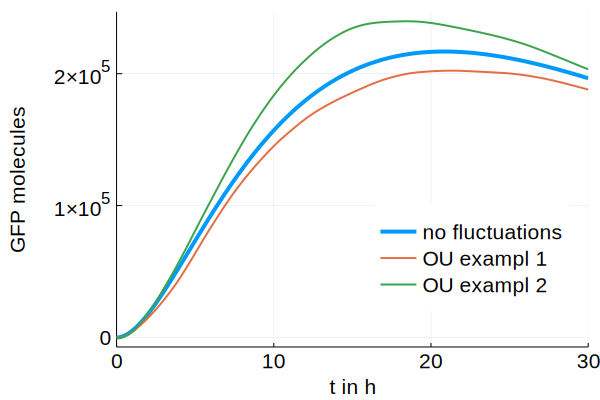

In [30]:
fig = plot(sol,vars=(0,3),label="no fluctuations",lw=4)
plot!(sol_time,sol_data[:,1],label="OU exampl 1",lw=2)
plot!(sol_time,sol_data[:,13],
    label="OU exampl 2",
    legend=:bottomright,
    ylabel="GFP molecules",
    xlabel="t in h",
    xtickfontsize=14,
    ytickfontsize=14,
    xguidefontsize=14,
    yguidefontsize=14,
    legendfontsize=14,
    foreground_color_legend = nothing,
yticks = ([0,1e5,2e5]),lw=2)
png("OUexamples.png")
fig